In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
home_dir = os.environ['HOME'] + '/'

In [2]:
import pyCloudy as pc

In [3]:
# Changing the location and version of the cloudy executable.
pc.config.cloudy_exe =  '/usr/local/Cloudy/c17.02/source/cloudy.exe'

In [4]:
# We define a function that will manage the input files of Cloudy. 
# This allow to easily change some parameters, very usefull to do a grid.
def make_model(dir_, model_name, dens, ab_O):
    full_model_name = '{0}_{1:.0f}_{2:.2f}'.format(model_name, dens, ab_O)
    r_min = 5e16
    dist = 1.26
    Teff = 45000
    qH = 47.
    options = ('no molecules',
                'no level2 lines',
                'no fine opacities',
                'atom h-like levels small',
                'atom he-like levels small',
                'COSMIC RAY BACKGROUND',
                'element limit off -8',
                )
    emis_tab = ['H  1  4861.33A',
            'H  1  6562.81A',
            'Ca B  5875.64A',
            'N  2  6583.45A',
            'O  1  6300.30A',
            'O  2  3726.03A',
            'O  2  3728.81A',
            'O  3  5006.84A',
            'BLND  4363.00A',
            'S  2  6716.44A',
            'S  2  6730.82A',
            'Cl 3  5517.71A',
            'Cl 3  5537.87A',
            'O  1  63.1679m',
            'O  1  145.495m',
            'C  2  157.636m']
    abund = {'He' : -0.92, 'C' : -3.15, 'N' : -4.0, 'Ne' : -4.00, 
             'S' : -5.35, 'Ar' : -5.80, 'Fe' : -7.4, 'Cl' : -7.00}
    abund['O'] = ab_O
    # Defining the object that will manage the input file for Cloudy
    c_input = pc.CloudyInput('{0}{1}'.format(dir_, full_model_name))
    # Filling the object with the parameters
    # Defining the ionizing SED: Effective temperature and luminosity.
    # The lumi_unit is one of the Cloudy options, like "luminosity solar", "q(H)", "ionization parameter", etc... 
    c_input.set_BB(Teff = Teff, lumi_unit = 'q(h)', lumi_value = qH)
    # Defining the density. You may also use set_dlaw(parameters) if you have a density law defined in dense_fabden.cpp.
    c_input.set_cste_density(dens)
    # Defining the inner radius. A second parameter would be the outer radius (matter-bounded nebula).
    c_input.set_radius(np.log10(r_min))
    c_input.set_abund(ab_dict = abund, nograins = True)
    c_input.set_other(options)
    c_input.set_iterate() # (0) for no iteration, () for one iteration, (N) for N iterations.
    c_input.set_sphere() # () or (True) : sphere, or (False): open geometry.
    c_input.set_emis_tab(emis_tab)
    c_input.set_distance(dist, 'kpc')
    c_input.print_input(to_file = True, verbose = False)


In [5]:
# The directory in which we will have the model
# You may want to change this to a different place so that the current directory
# will not receive all the Cloudy files.
dir_ = '/tmp/models/'

In [6]:
#writing the makefile in the directory dir_
pc.print_make_file(dir_ = dir_)

In [7]:
# setting verbosity to medium level, change to 3 for high verbosity
pc.log_.level = 2

In [8]:
# Generic name of the models
model_name = 'model_2'

In [9]:
# tables for the values of the density and the log(O/H)
tab_dens = [3, 4, 5, 6]
tab_ab_O = [-3.1, -3.25, -3.4, -3.55, -3.7]

In [10]:
# defining the models and writing 20 input files
for dens in tab_dens:
    for ab_O in tab_ab_O:
        make_model(dir_, model_name, dens, ab_O)

In [11]:
# Running the models using the makefile and n_proc processors
n_proc = 8
# Take, care, this will run 20 cloudy models on 8 processors! May take some time. 
# If you run all the models togeter (n_proc = 20), you will need 10 Go RAM.
pc.run_cloudy(dir_ = dir_, n_proc = n_proc, model_name = model_name, use_make = True)

In [12]:
# reading the Cloudy outputs and putting them in a list of CloudyModel objects
Ms = pc.load_models('{0}{1}'.format(dir_, model_name), read_grains = False)

In [13]:
#Computing line intensity ratios 
rO3 = [np.log10(M.get_emis_vol('O__3_500684A')/M.get_emis_vol('BLND_436300A')) for M in Ms]
rO2 = [np.log10(M.get_emis_vol('O__2_372603A')/M.get_emis_vol('O__2_372881A')) for M in Ms]

In [14]:
# defining the colors associated to the Oxygen abundances
col = [M.abund['O'] for M in Ms]

In [15]:
# defining the size as the density (at the first step, but in these models it's constant)
#size = [np.log10(M.nH[0])*20 for M in Ms]
size = [40*(5+M.log_U_mean) for M in Ms]

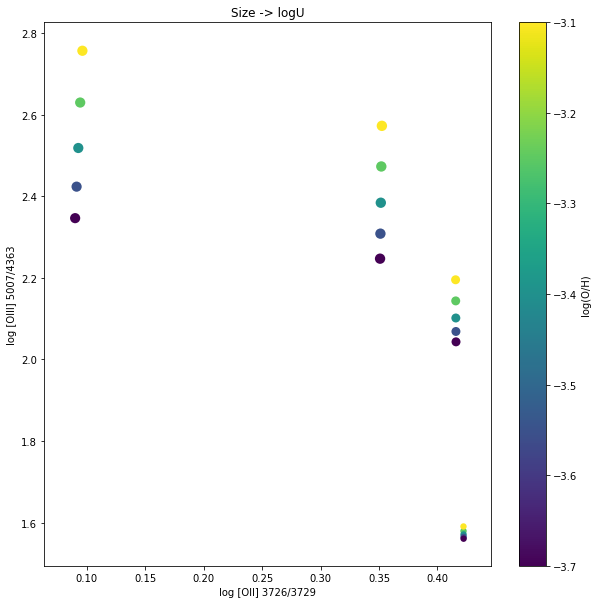

In [16]:
plt.figure(figsize=(10,10))
plt.scatter(rO2, rO3, c=col, s=size, edgecolors = 'none')
plt.xlabel('log [OII] 3726/3729')
plt.ylabel('log [OIII] 5007/4363')
cb = plt.colorbar()
cb.set_label('log(O/H)')
plt.title('Size -> logU');